#### This is a notebook for learning Generalised Least Squares (GLS) regression and Weighted Least Squares regression (WLS)
GLS is a technique for estimating unknown parameters in a LR model when there is a certain degree of correlation between the residuals in a regression model. 
https://en.wikipedia.org/wiki/Generalized_least_squares

WLS is a generalisation of OLS and LR in which knowledge of the variance of observations is incorporated into the regression.
https://en.wikipedia.org/wiki/Weighted_least_squares

In [34]:
## Packages
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import cvxopt
from scipy import stats
from statsmodels.iolib.table import SimpleTable, default_txt_fmt
np.random.seed(1024)
%matplotlib inline

In [14]:
data = sm.datasets.longley.load()
data.exog = sm.add_constant(data.exog)
data.exog = pd.DataFrame(data.exog, columns = ['const','GNPDEFL','GNP','UNEMP','ARMED','POP','YEAR'])
# for this the longely time series dataset is used and assumed to be heteroskedastic. 
# We can define the sigma and use it to give a GLS model.

In [15]:
## obtaining the residuals
ols_resid = sm.OLS(data.endog, data.exog).fit().resid

In [16]:
ols_resid

0     267.340030
1     -94.013942
2      46.287168
3    -410.114622
4     309.714591
5    -249.311215
6    -164.048956
7     -13.180357
8      14.304773
9     455.394095
10    -17.268927
11    -39.055042
12   -155.549974
13    -85.671308
14    341.931514
15   -206.757825
dtype: float64

In [21]:
## fitting a model based on the residuals
resid_fit = sm.OLS(
    np.asarray(ols_resid)[1:], sm.add_constant(np.asarray(ols_resid)[:-1])).fit()
print(resid_fit.tvalues[1])
print(resid_fit.pvalues[1])

-1.4390229839791866
0.17378444788658856


We do not have evidence that the errors follow an AR(1) process but we continue. An AR(1) process means that near-neighbours have a stronger relation so we can give this structure by using a toeplitz matrix.

In [22]:
from scipy.linalg import toeplitz

toeplitz(range(5))

array([[0, 1, 2, 3, 4],
       [1, 0, 1, 2, 3],
       [2, 1, 0, 1, 2],
       [3, 2, 1, 0, 1],
       [4, 3, 2, 1, 0]])

In [29]:
order = toeplitz(range(len(ols_resid)))
# This ensures that our error covariance is actually rho**order which defines an autocorrelation structure. 
# But thie exact rho in this instance is not known so we will use a feasible GLS, which currently only has 1 experimental support.

In [30]:
# A GLSAR model with one lag will be used
glsar_model = sm.GLSAR(data.endog, data.exog, 1)
glsar_results = glsar_model.iterative_fit(1)
print(glsar_results.summary())

                           GLSAR Regression Results                           
Dep. Variable:                      y   R-squared:                       0.996
Model:                          GLSAR   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     295.2
Date:                Tue, 19 Oct 2021   Prob (F-statistic):           6.09e-09
Time:                        12:20:27   Log-Likelihood:                -102.04
No. Observations:                  15   AIC:                             218.1
Df Residuals:                       8   BIC:                             223.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.468e+06   8.72e+05     -3.979      0.0

C:\Users\darre\Anaconda3\lib\site-packages\scipy\stats\stats.py:1604: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


In [33]:
print(glsar_results.params)
print(glsar_results.bse) ## standard error

const     -3.467961e+06
GNPDEFL    3.455678e+01
GNP       -3.434101e-02
UNEMP     -1.962144e+00
ARMED     -1.001973e+00
POP       -9.780460e-02
YEAR       1.823183e+03
dtype: float64
const      871584.051696
GNPDEFL        84.733715
GNP             0.032803
UNEMP           0.480545
ARMED           0.211384
POP             0.224774
YEAR          445.828748
dtype: float64


#### Weighted least squares regression
https://www.statsmodels.org/stable/examples/notebooks/generated/wls.html

Model assumptions:
Misspecification: true model is quadratic, estimate only linear
Independent noise/error term
Two groups for error variance, low and high variance groups

In [61]:
nsample = 50
x = np.linspace(0, 20, nsample) # returns evenly spaced numbers over the range
X = np.column_stack((x, (x-5) **2)) # stack 1-D arrays as columns into a 2-D array. but remains 50 in len
X = sm.add_constant(X) ## adds 1 to the front of each array
beta = [5.0, 0.5, -0.01]
sig = 0.5
w = np.ones(nsample)
w[nsample * 6 // 10 :] = 3
y_true = np.dot(X, beta)
e = np.random.normal(size = nsample)
y = y_true + sig * w * e
X = X[: , [0, 1]]

In [63]:
# WLS knowing the true variance ratio of heteroscedasticity
# w is the stdev of the error and WLS requires that the weights are proportional to the inverse of the error variance

mod_wls = sm.WLS(y, X, weights = 1.0 / (w ** 2))
res_wls = mod_wls.fit()
print(res_wls.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.902
Model:                            WLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     440.8
Date:                Tue, 19 Oct 2021   Prob (F-statistic):           7.78e-26
Time:                        12:56:50   Log-Likelihood:                -56.879
No. Observations:                  50   AIC:                             117.8
Df Residuals:                      48   BIC:                             121.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3801      0.160     33.632      0.0

In [64]:
## estimating an OLS model for comparison
res_ols = sm.OLS(y, X).fit()
print(res_ols.params)
print(res_wls.params)

[5.5859567  0.37897943]
[5.38010958 0.42471014]


In [73]:
# comparing the WLS standard errors to heteroscedasticity corrected OLS std errors
se = np.vstack(
    [
        [res_wls.bse], # std error
        [res_ols.bse], # std error
        [res_ols.HC0_se],
        [res_ols.HC1_se],
        [res_ols.HC2_se],
        [res_ols.HC3_se],
    ]
)
se = np.round(se, 4)
colnames = ["x1", "const"]
rownames = ["WLS", "OLS", "OLS_HC0", "OLS_HC1", "OLS_HC3", "OLS_HC3"]
tabl = SimpleTable(se, colnames, rownames, txt_fmt=default_txt_fmt)
print(tabl)

          x1   const 
---------------------
WLS       0.16 0.0202
OLS     0.2697 0.0232
OLS_HC0 0.1884 0.0242
OLS_HC1 0.1923 0.0247
OLS_HC3  0.194 0.0249
OLS_HC3 0.1997 0.0256
---------------------


In [78]:
# calculates the OLS prediction interval
covb = res_ols.cov_params()
prediction_var = res_ols.mse_resid + (X * np.dot(covb, X.T).T).sum(1)
prediction_std = np.sqrt(prediction_var)
tppf = stats.t.ppf(0.975, res_ols.df_resid)

In [79]:
pred_ols = res_ols.get_prediction()
iv_l_ols = pred_ols.summary_frame()["obs_ci_lower"]
iv_u_ols = pred_ols.summary_frame()["obs_ci_upper"]

C:\Users\darre\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\darre\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


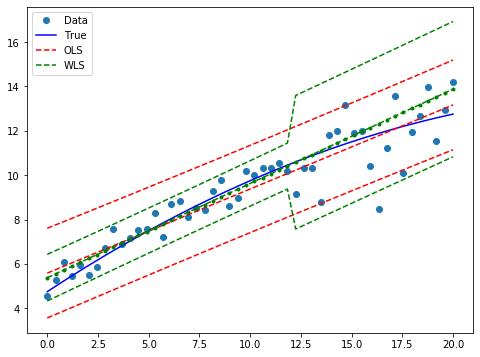

In [80]:
pred_wls = res_wls.get_prediction()
iv_l = pred_wls.summary_frame()["obs_ci_lower"]
iv_u = pred_wls.summary_frame()["obs_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, "o", label="Data")
ax.plot(x, y_true, "b-", label="True")
# OLS
ax.plot(x, res_ols.fittedvalues, "r--")
ax.plot(x, iv_u_ols, "r--", label="OLS")
ax.plot(x, iv_l_ols, "r--")
# WLS
ax.plot(x, res_wls.fittedvalues, "g--.")
ax.plot(x, iv_u, "g--", label="WLS")
ax.plot(x, iv_l, "g--")
ax.legend(loc="best")

#### Extra notes on calculating weights for WLS ####
If a Y is a continuous variable, the typical strategy is to use a simple OLS regression to get the residuals, and then regress one of the functions, such as the root absolute deviation, onto X. The predicted value of this function is used for the weight associated with that point. 

Getting your weights from the OLS model is reasonable because the OLS model is unbiased, even in the presence of heteroscedasticity. 

Other weight approaches include weighting the sum of the squares of the differences (residuals). 

https://www.azdhs.gov/documents/preparedness/state-laboratory/lab-licensure-certification/technical-resources/calibration-training/11-weighted-least-squares-regression-calib.pdf

Other ways which can place more emphasis on numbers of smaller values are: 
- wi = 1 / yi or; this nearly cancels out the weighting of higher amounts
- wi = 1 / yi^2 this causes over proportional weighting of smaller amounts
- the residual variance - teh sum of squared differences between the predicted and observed data points


WLS, though, is based on the idea that the weights are known exactly, which is not necessarily true. Also sensitive to outliers.